In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

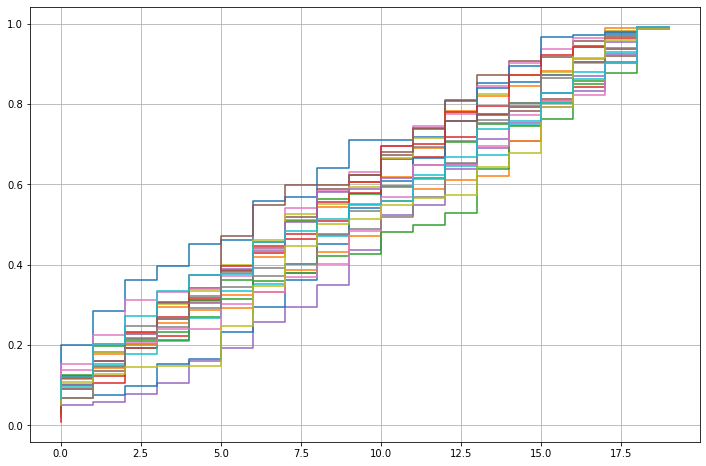

In [3]:
# First try
K = 20

plt.figure(figsize=(12, 8), facecolor='white')

for _ in range(20):
    x = np.random.random(K)
    plt.step(np.arange(K), np.cumsum(x)/(x.sum()+1e-1))

plt.grid(True)
plt.show()

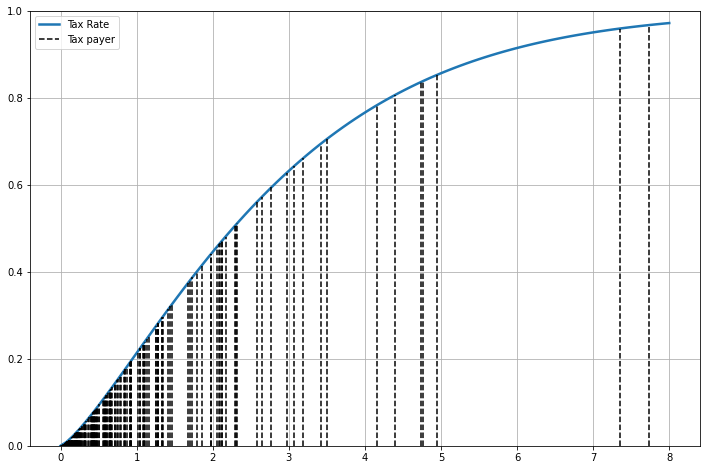

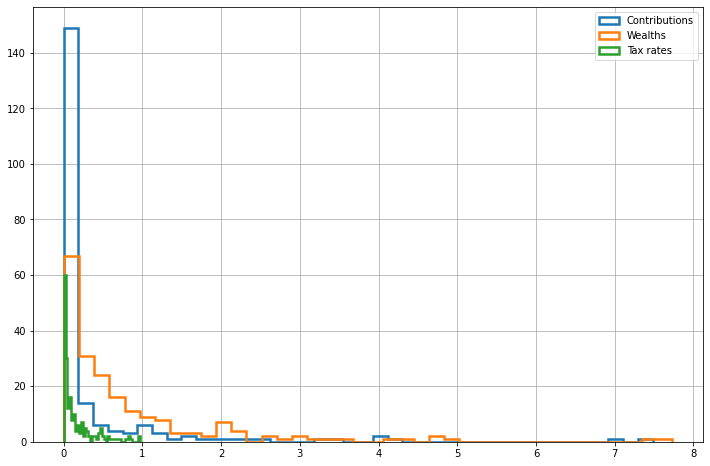

In [4]:

np.random.seed(42)

# Second try - Weibull CDF
def weibull_cdf(x, l, k):
    return 1 - np.exp(-(x/l)**k)

N = 200
n_tax_bins = 100
bins = np.linspace(0, 8, n_tax_bins)
tax_rates = weibull_cdf(bins, 3, 1.3)
wealths = np.random.pareto(2, N)

plt.figure(facecolor='white', figsize=(12, 8))
plt.plot(bins, weibull_cdf(bins, 3, 1.3), linewidth=2.5, label='Tax Rate')
plt.vlines(wealths, 0, weibull_cdf(wealths, 3, 1.3), colors='k', linestyles='--', label='Tax payer')
plt.grid(True)
plt.legend()
plt.ylim([0, 1.0])

plt.figure(facecolor='white', figsize=(12, 8))
plt.hist(wealths * weibull_cdf(wealths, 3, 1.3), bins=40, histtype='step', label='Contributions', linewidth=2.5)
plt.hist(wealths, bins=40, histtype='step', label='Wealths', linewidth=2.5)
plt.hist(weibull_cdf(wealths, 3, 1.3), bins=40, histtype='step', label='Tax rates', linewidth=2.5)
plt.grid(True)
plt.legend()
    

In [57]:
def save_results(T = 20, N = 100):
    r = np.zeros((T, N))
    s = np.zeros(T)
    w = np.zeros(T)
    income_propensity = np.random.pareto(2, N)
    incomes = np.min(np.random.normal(income_propensity, 0.2 * income_propensity), 0) + 1e-3
    for t in range(T):
        incomes += np.random.normal(income_propensity, 0.2 * income_propensity)
        contrib = weibull_cdf(incomes, 3, 1.3)
        w = contrib / contrib.sum()
        net_income = contrib.sum()/N - contrib
        incomes += net_income
        negative_transfers = net_income[net_income < 0].sum()
        r[t] = incomes
        s[t] = negative_transfers

    return r, s

r, s = save_results(100, 50)

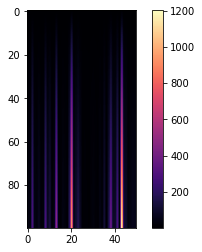

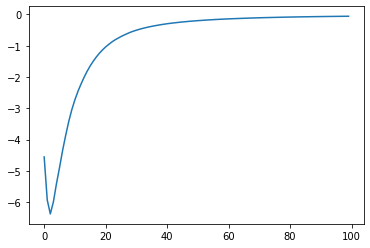

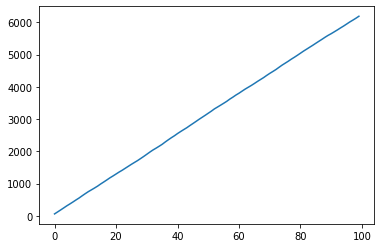

In [59]:
plt.imshow(r, cmap='magma')
plt.colorbar()

plt.figure()
plt.plot(s, label='demo transfer')

plt.figure()
plt.plot(r.sum(1), label='demo total wealth')

## Experiment 1 with votes on the change of tax structure

In [5]:
# Second try - Weibull CDF
def weibull_cdf(x, l, k):
    return 1 - np.exp(-(x/l)**k)
    
def save_results(T = 20, N = 100, meritocracy=False):
    r = np.zeros((T, N))
    s = np.zeros(T)
    votes = np.zeros(T)
    tax_rates = np.zeros((T, 2))
    proposed_tax_rates = np.zeros((T, 2))
    income_propensity = np.random.pareto(2, N)
    incomes = np.maximum(np.random.normal(income_propensity, 0.2 * income_propensity), 1e-3)
    current_tax_rate = (10, 1)
    
    for t in range(T):
        # Propose new tax rate, to start from next iteration
        proposed_tax_rate = current_tax_rate + np.random.normal(0, 1, 2)
        proposed_tax_rate = np.maximum(proposed_tax_rate, 1e-3)

        # Add income from labour
        labour_income = np.random.normal(income_propensity, 0.2 * income_propensity)
        incomes += labour_income
        
        # Contribution calculated using proposed tax rates
        hypothetical_contrib = labour_income * weibull_cdf(labour_income, proposed_tax_rate[0], proposed_tax_rate[1])

        # Hypothetical benefit
        hypothetical_net_income = hypothetical_contrib.sum()/N - hypothetical_contrib
        
        # Contribution calculated using current tax rates
        contrib = labour_income * weibull_cdf(labour_income, current_tax_rate[0], current_tax_rate[1])
        
        # Real benefit
        net_income = contrib.sum()/N - contrib

        # Individual votes
        v = hypothetical_net_income > net_income

        # Weights using current contributions
        if meritocracy == True:
            w = contrib / contrib.sum()
        else:
            w = np.ones(N)/N
        
        # Vote outcome
        V = (w * v).sum() / w.sum() > 0.5
        
        # Add distribution income to your income
        incomes += net_income
        
        # Compute negative transfers
        negative_transfers = np.abs(net_income[net_income < 0].sum())
        # money_sink = net_income[net_income < 0].sum()

        r[t] = incomes
        s[t] = negative_transfers
        votes[t] = V
        tax_rates[t] = current_tax_rate
        proposed_tax_rates[t] = proposed_tax_rate

        # If vote accepted, change tax rate
        if V:
            current_tax_rate = proposed_tax_rate

    return r, s, votes, tax_rates, proposed_tax_rates, income_propensity

In [6]:
np.random.seed(42)
r, s, votes, tax_rates, proposed_tax_rates, inc_prop = save_results(750, 500, meritocracy=False)
np.random.seed(42)
r2, s2, votes2, tax_rates2, proposed_tax_rates2, inc_prop2 = save_results(750, 500, meritocracy=True)

# plots(r, s, votes, tax_rates, proposed_tax_rates)
# plots(r2, s2, votes2, tax_rates2, proposed_tax_rates2)


/tmp/ipykernel_273/1067253310.py:41: RuntimeWarning: invalid value encountered in divide
  w = contrib / contrib.sum()


## Results
- As $T \rightarrow \infty$, in the meritocratic case, we reach zero taxation, a free society.
- As $T \rightarrow \infty$, in the democratic case, we reach 100% taxation, or uniform division of all contributions - a communist society.

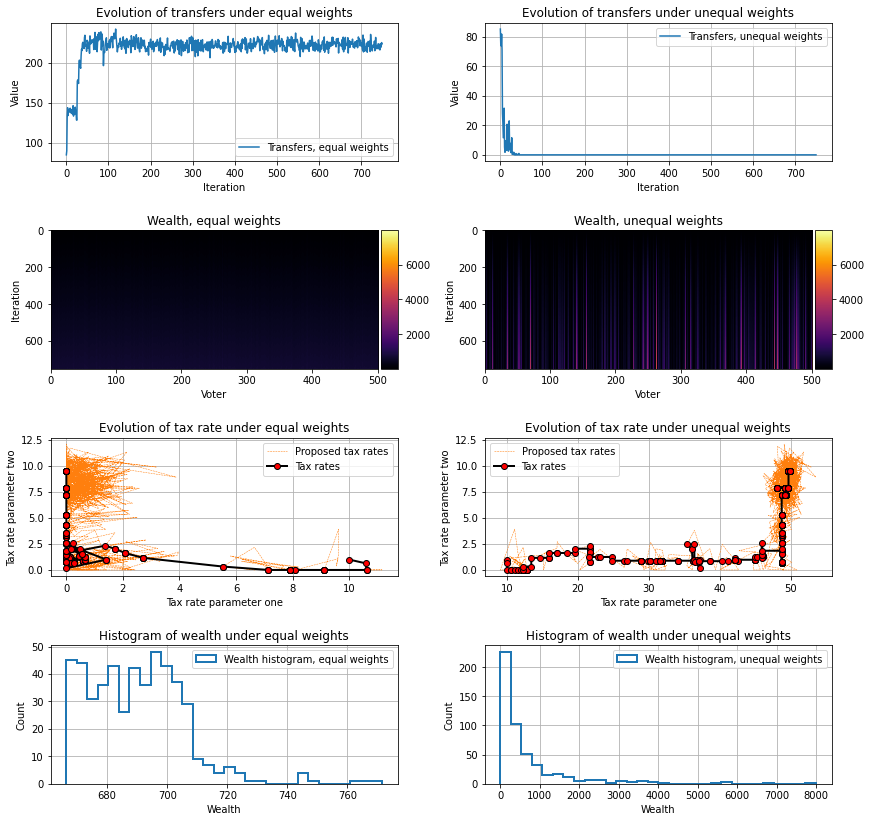

In [36]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 14), facecolor='white')

axes[0, 0].plot(s, label='Transfers, equal weights', linewidth=1.5)
axes[0, 1].plot(s2, label='Transfers, unequal weights', linewidth=1.5)
axes[0, 0].set(xlabel="Iteration", ylabel="Value", title="Evolution of transfers under equal weights")
axes[0, 0].grid()
axes[0, 0].legend()
axes[0, 1].set(xlabel="Iteration", ylabel="Value", title="Evolution of transfers under unequal weights")
axes[0, 1].grid()
axes[0, 1].legend()


axes[2, 0].plot(proposed_tax_rates[:, 0], proposed_tax_rates[:, 1], label='Proposed tax rates', 
                linestyle='--', markeredgecolor='k', linewidth=0.5, c="C1")
axes[2, 0].plot(tax_rates[:, 0], tax_rates[:, 1], c="k", markeredgecolor='k',  label='Tax rates', marker='o', markerfacecolor='red', linewidth=2)
axes[2, 1].plot(proposed_tax_rates2[:, 0], proposed_tax_rates[:, 1], label='Proposed tax rates', 
                linestyle='--', markeredgecolor='k', linewidth=0.5, c="C1")
axes[2, 1].plot(tax_rates2[:, 0], tax_rates[:, 1], c="k", markeredgecolor='k', label='Tax rates', marker='o', markerfacecolor='red', linewidth=2)
axes[2, 0].grid()
axes[2, 0].legend()
axes[2, 1].grid()
axes[2, 1].legend()
axes[2, 0].set(xlabel="Tax rate parameter one", ylabel="Tax rate parameter two", title="Evolution of tax rate under equal weights")
axes[2, 1].set(xlabel="Tax rate parameter one", ylabel="Tax rate parameter two", title="Evolution of tax rate under unequal weights")

# axes[0, 1].grid()
# axes[0, 1].legend()
# axes[0, 1].set(xlabel="Wealth", ylabel="Count", title="Histogram of wealth under equal and unequal weights")

# plt.figure(figsize=(20, 8), facecolor='white')

# find minimum of minima & maximum of maxima
minmin = np.min([np.min(r), np.min(r2)])
maxmax = np.max([np.max(r), np.max(r2)])

im1 = axes[1, 0].imshow(r, vmin=minmin, vmax=maxmax,
                    extent=(0, 500, 750, 0), aspect='auto', cmap='inferno')
divider = make_axes_locatable(axes[1, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

axes[1, 0].set(xlabel="Voter", ylabel="Iteration", title="Wealth, equal weights")
axes[1, 1].set(xlabel="Voter", ylabel="Iteration", title="Wealth, unequal weights")
im2 = axes[1, 1].imshow(r2, vmin=minmin, vmax=maxmax,
                    extent=(0,500,750,0), aspect='auto', cmap='inferno')

divider2 = make_axes_locatable(axes[1,1])
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')

# # add space for colour bar
# cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
# fig.colorbar(im2, cax=cbar_ax)

axes[3, 0].hist(r[-1], bins=30, histtype='step', linewidth=2, label='Wealth histogram, equal weights')
axes[3, 1].hist(r2[-1], bins=30, histtype='step', linewidth=2, label='Wealth histogram, unequal weights')
axes[3, 0].grid()
axes[3, 0].legend()
axes[3, 1].grid()
axes[3, 1].legend()
axes[3, 0].set(xlabel="Wealth", ylabel="Count", title="Histogram of wealth under equal weights")
axes[3, 1].set(xlabel="Wealth", ylabel="Count", title="Histogram of wealth under unequal weights")
fig.subplots_adjust(wspace=0.25, hspace=0.5)
plt.savefig("weighted_voting_simulation4.svg", dpi=250, bbox_inches='tight')

In [7]:
tax_rates2[-1]

array([51.3414178 , 33.92209946])

0.9160097327552453 458.00486637762265


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

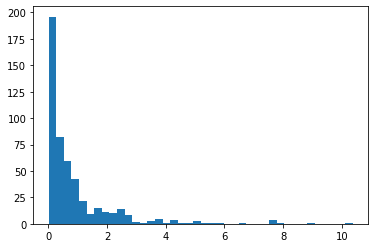

In [19]:
np.random.seed(42)

incomes = np.maximum(np.random.normal(inc_prop, 0.2 * inc_prop), 1e-3)
print(incomes.mean(), incomes.sum())

plt.hist(incomes, bins=40)

incomes * weibull_cdf(incomes, tax_rates2[-1, 0], tax_rates2[-1, 1])

In [92]:
r2

array([[8.06205514e-01, 7.84633451e+00, 2.31841310e+00, ...,
        3.30099197e-01, 9.61590683e+00, 1.42068684e+01],
       [1.29845684e+00, 1.02956920e+01, 3.67682561e+00, ...,
        5.86389396e-01, 1.27821770e+01, 1.79606240e+01],
       [1.74258006e+00, 1.29371466e+01, 4.72048353e+00, ...,
        8.44495088e-01, 1.53684793e+01, 2.14875193e+01],
       ...,
       [2.00982231e+02, 2.61939210e+03, 6.97839471e+02, ...,
        3.27338005e+01, 3.93096208e+03, 5.63655575e+03],
       [2.01269543e+02, 2.62347490e+03, 6.98638284e+02, ...,
        3.27764817e+01, 3.93449361e+03, 5.64538266e+03],
       [2.01585941e+02, 2.62811599e+03, 6.99496351e+02, ...,
        3.28217897e+01, 3.94154130e+03, 5.65304331e+03]])

In [4]:
def entropy(x):
    x = x + 1e-7
    p = x/x.sum()
    return -(p * np.log2(p)).sum()

def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

def describe(x):
    print("mean", x.mean(), "std", x.std(), "entropy", entropy(x), "gini", gini(x))

describe(r[-1])
describe(r2[-1])

mean 690.0148894569637 std 16.102650411717985 entropy 8.965394627167072 gini 0.012631350966671371
mean 690.0148894569638 std 1046.9270728666145 entropy 7.905411721893685 gini 0.6315707166878903
